# Expected Value Modeling for NBA Shot Locations

We should expect that two important drivers of the likelihood of making a shot are the shot distance and how near the closest defender is.  Using data obtained from NBA.com for the 2014-2015 season, this demo explores how you can build an expected value model for shooting.

## Setup

In [1]:
%run ../../utils/notebook_setup.py

Adding datascience helper tools to path...
Setting up Matplotlib...
matplotlib imported as mpl
matplotlib.pyplot imported as plt
seaborn imported as sns


In [2]:
import pandas as pd
import numpy as np

from datascience_utils import hexbin_plot, sorted_boxplot
from datascience_topic import build_expected_shot_values_from_hexbin

import pygam
from pygam import LogisticGAM, s as gam_spline, te as gam_interaction
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from mpl_toolkits import mplot3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from scipy.stats import binned_statistic_2d

## Drawing Functions

In [3]:
def shot_value(XX, YY):
    RR = np.sqrt(XX**2 + YY**2)
    out = 2 * np.ones_like(RR)
    out[RR >= 237.5] = 3.
    out[(YY <= -47.5 + 140) & ((XX < -220) | (XX >= 220))] = 3.
    return out
    

def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    """Drawing a Basketball court in MPL from Savvas Tjortjoglou"""
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
#     corner_three_a = ConnectionPatch((-220, -47.5), (-220, -47.5 + 140))
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 137, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, 
#                     theta1=22.132391401475683, theta2=157.86760859852433,
                    theta1=22, theta2=158, 
                    linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

        
    # Adjust the axis limits and orientation of the plot in order
    # to plot half court, with the hoop by the top of the plot
    ax.set_xlim(-250,250)
    ax.set_ylim(422.5, -47.5)

    # Get rid of axis labels and tick marks
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.tick_params(labelbottom='off', labelleft='off')
    ax.set_aspect('equal')

    return ax

def draw_heatmap_on_court(XX, YY, ZZ, title, cax_tick_labels=None, 
                          vmin=None, vmax=None, cmap='viridis', figsize=(8, 8),
                          ZZ_min=None, ZZ_rng=None):
    fig, ax = plt.subplots(figsize=figsize)
    # build court
    draw_court(ax=ax)
    # make heatmap
    im = ax.pcolormesh(XX, YY, ZZ, cmap=cmap, vmin=vmin, vmax=vmax)
    # make colorbar
    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("top", size="7%", pad="4%")
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_tick_params(labelsize=16)
    cb.set_label(title, fontsize=16)
    if cax_tick_labels is not None:
        cax.xaxis.set_ticklabels(cax_tick_labels)
    if ZZ_min is not None and ZZ_rng is not None:
        cax_tick_labels = map(
            lambda x: "{:.3g}".format(x),
            10**(cax.xaxis.get_majorticklocs() * ZZ_rng + ZZ_min)
        )
        cax.xaxis.set_ticklabels(cax_tick_labels)
    plt.tight_layout()

def draw_fraction_fga(XX, YY, fga_hist, title, ZZ_min=-5., ZZ_rng=4.5):
    ZZ = np.ma.log10(fga_hist)
    ZZ = (ZZ - ZZ_min) / ZZ_rng
    draw_heatmap_on_court(
        XX, YY, ZZ, title, vmin=0., vmax=1., ZZ_min=ZZ_min, ZZ_rng=ZZ_rng)
    
def draw_fg_pct(XX, YY, fgpct, title, vmin=.2, vmax=.55):
    pct_min = round(vmin * 100)
    pct_max = round(vmax * 100)
    cax_tick_labels = [f'<{pct_min}%'] + \
        [f"{x}%" for x in range(pct_min + 5, pct_max, 5)] + [f'>{pct_max}%']
    draw_heatmap_on_court(
        XX, YY, fgpct, title, cax_tick_labels=cax_tick_labels, vmin=vmin, vmax=vmax)
    
    
def draw_ppa(XX, YY, ppa, title, vmin=.6, vmax=1.5):
    cax_tick_labels = [f'<{vmin:.2f}'] + \
        [f"{x:.2f}" for x in np.arange(vmin + .1, vmax, .1)] + [f'>{vmax:.2f}']
    draw_heatmap_on_court(
        XX, YY, ppa, title, cax_tick_labels=cax_tick_labels, vmin=vmin, vmax=vmax)

def shot_chart(x, y, title="", kind="scatter", color="b", cmap=None,
               xlim=(-250, 250), ylim=(422.5, -47.5),
               court_color="gray", outer_lines=False, court_lw=1,
               flip_court=False, kde_shade=True, hex_gridsize=None,
               ax=None, **kwargs):
    """
    Returns an Axes object with player shots plotted.
    TODO: explain the parameters
    """

    if ax is None:
        ax = plt.gca()

    if cmap is None:
        cmap = sns.light_palette(color, as_cmap=True)

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")

    ax.set_title(title, fontsize=18)

    draw_court(ax, color=court_color, lw=court_lw, outer_lines=outer_lines)

    if kind == "scatter":
        ax.scatter(x, y, c=color, **kwargs)

    elif kind == "kde":
        sns.kdeplot(x, y, shade=kde_shade, cmap=cmap,
                    ax=ax, **kwargs)
        ax.set_xlabel('')
        ax.set_ylabel('')

    elif kind == "hex":
        if hex_gridsize is None:
            # Get the number of bins for hexbin using Freedman-Diaconis rule
            # This is idea was taken from seaborn, which got the calculation
            # from http://stats.stackexchange.com/questions/798/
            from seaborn.distributions import _freedman_diaconis_bins
            x_bin = _freedman_diaconis_bins(x)
            y_bin = _freedman_diaconis_bins(y)
            hex_gridsize = int(np.mean([x_bin, y_bin]))

        ax.hexbin(x, y, gridsize=hex_gridsize, cmap=cmap, **kwargs)

    else:
        raise ValueError("kind must be 'scatter', 'kde', or 'hex'.")
    
    return ax


def plot_fgpct_radial_dependence(gam_model, title, plot_cis=False, figsize=(12, 4)):
    fig, ax = plt.subplots(figsize=figsize)
    XX = gam_model.generate_X_grid(0)
    pdep, confi = gam_model.partial_dependence(0, width=.95)
    ax.plot(XX[:, 0], 1 / (1 + np.exp(-pdep)))
    if plot_cis:
        ax.plot(XX[:, 0], 1 / (1 + np.exp(-confi[:, 0])), c='grey', ls='--')
        ax.plot(XX[:, 0], 1 / (1 + np.exp(-confi[:, 1])), c='grey', ls='--')
    ax.set_title(title)

    
def plot_fgpct_surface(gam_model, title, figsize=(8, 6), vmin=.2, vmax=.55,
                       x_grid=np.arange(-250, 260, 10), y_grid=np.arange(0, 430, 10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection='3d')
    ax.set_title(title)
    
    XX, YY = np.meshgrid(x_grid, y_grid)
    RR = np.sqrt(XX**2 + YY**2)
    TT = np.arccos(XX / (RR + 1e-8))
    Z = gam_model.predict_proba(np.vstack([RR.ravel(), TT.ravel()]).T).\
        reshape(XX.shape)
    surf = ax.plot_surface(XX, YY, Z, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_ylim(400, 0)
    
    cb = fig.colorbar(surf, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_tick_params(labelsize=16)
    
    pct_min = round(vmin * 100)
    pct_max = round(vmax * 100)
    cax_tick_labels = [f'<{pct_min}%'] + \
        [f"{x}%" for x in range(pct_min + 5, pct_max, 5)] + [f'>{pct_max}%']
    cb.ax.xaxis.set_ticklabels(cax_tick_labels)
    
    plt.tight_layout()
    
def plot_ptsperfga_surface(gam_model, title, figsize=(8, 6), vmin=.6, vmax=1.5,
                       x_grid=np.arange(-250, 260, 10), y_grid=np.arange(0, 430, 10)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection='3d')
    ax.set_title(title)
    
    XX, YY = np.meshgrid(x_grid, y_grid)
    RR = np.sqrt(XX**2 + YY**2)
    TT = np.arccos(XX / (RR + 1e-8))
    FGPCT = gam_model.predict_proba(np.vstack([RR.ravel(), TT.ravel()]).T).\
        reshape(XX.shape)
    PTS = shot_value(XX, YY)
    Z = FGPCT * PTS
    surf = ax.plot_surface(XX, YY, Z, cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_ylim(400, 0)
    
    cb = fig.colorbar(surf, orientation="horizontal")
    cb.ax.xaxis.set_ticks_position("top")
    cb.ax.xaxis.set_tick_params(labelsize=16)
    
    cax_tick_labels = [f'<{vmin}'] + \
        [f"{np.round(x, 1)}" for x in np.arange(vmin + .1, vmax, .1)] + [f'>{vmax}']
    cb.ax.xaxis.set_ticklabels(cax_tick_labels)
    
    plt.tight_layout()
    
def plot_fgpct_heatmap(gam_model, title, figsize=(8, 8),
                       x_grid=np.arange(-250, 260, 10), 
                       y_grid=np.arange(0, 430, 10),
                       vmin=.2, vmax=.55):
    fig, ax = plt.subplots(figsize=figsize)
    draw_court(ax=ax, outer_lines=True)
    
    XX, YY = np.meshgrid(x_grid, y_grid)
    RR = np.sqrt(XX**2 + YY**2)
    TT = np.arccos(XX / (RR + 1e-8))
    Z = gam_model.predict_proba(np.vstack([RR.ravel(), TT.ravel()]).T).\
        reshape(XX.shape)
    im = ax.pcolormesh(XX, YY, Z, vmin=vmin, vmax=vmax)

    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("top", size="7%", pad="4%")
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_tick_params(labelsize=16)
    
    pct_min = round(vmin * 100)
    pct_max = round(vmax * 100)
    cax_tick_labels = [f'<{pct_min}%'] + \
        [f"{x}%" for x in range(pct_min + 5, pct_max, 5)] + [f'>{pct_max}%']
    cax.xaxis.set_ticklabels(cax_tick_labels)

    cb.set_label(title, fontsize=16)
    plt.tight_layout()
    
def plot_ptsperfga_heatmap(gam_model, title, figsize=(8, 8),
                       x_grid=np.arange(-250, 260, 10), 
                       y_grid=np.arange(0, 430, 10),
                       vmin=.6, vmax=1.5):
    fig, ax = plt.subplots(figsize=figsize)
    draw_court(ax=ax, outer_lines=True)
    
    XX, YY = np.meshgrid(x_grid, y_grid)
    RR = np.sqrt(XX**2 + YY**2)
    TT = np.arccos(XX / (RR + 1e-8))
    FGPCT = gam_model.predict_proba(np.vstack([RR.ravel(), TT.ravel()]).T).\
        reshape(XX.shape)
    PTS = shot_value(XX, YY)
    Z = FGPCT * PTS
    im = ax.pcolormesh(XX, YY, Z, vmin=vmin, vmax=vmax)

    ax_divider = make_axes_locatable(ax)
    cax = ax_divider.append_axes("top", size="7%", pad="4%")
    cb = fig.colorbar(im, cax=cax, orientation="horizontal")
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_tick_params(labelsize=16)
    
    cax_tick_labels = [f'<{vmin}'] + \
        [f"{np.round(x, 1)}" for x in np.arange(vmin + .1, vmax, .1)] + [f'>{vmax}']
    cax.xaxis.set_ticklabels(cax_tick_labels)

    cb.set_label(title, fontsize=16)
    plt.tight_layout()


## Load Data

In [4]:
shot_charts = {
    year: pd.read_csv(f'shot_charts_{year}.csv.gz')
    for year in range(2013, 2018)
}

shot_charts_df = pd.concat(shot_charts).\
    reset_index(level=0).\
    rename({'level_0': 'SEASON'}, axis=1).\
    reset_index(drop=True)

shot_charts_df['PTS_TYPE'] = 2 * (shot_charts_df['SHOT_TYPE'] == '2PT Field Goal') + \
    3 * (shot_charts_df['SHOT_TYPE'] == '3PT Field Goal')
shot_charts_df['PTS'] = shot_charts_df['SHOT_MADE_FLAG'] * shot_charts_df['PTS_TYPE']
shot_charts_df.head()

,SEASON,ACTION_TYPE,EVENT_TYPE,GAME_DATE,GAME_EVENT_ID,GAME_ID,GRID_TYPE,HTM,LOC_X,LOC_Y,...,SHOT_MADE_FLAG,SHOT_TYPE,SHOT_ZONE_AREA,SHOT_ZONE_BASIC,SHOT_ZONE_RANGE,TEAM_ID,TEAM_NAME,VTM,PTS_TYPE,PTS
0,2013,Jump Shot,Missed Shot,NaN,2.0,21300001,Shot Chart Detail,NaN,-38.0,45.0,...,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1.611e+09,Indiana Pacers,NaN,2,0.0
1,2013,Pullup Jump shot,Made Shot,NaN,5.0,21300001,Shot Chart Detail,NaN,105.0,164.0,...,1.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1.611e+09,Indiana Pacers,NaN,2,2.0
2,2013,Jump Shot,Missed Shot,NaN,6.0,21300001,Shot Chart Detail,NaN,51.0,266.0,...,0.0,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1.611e+09,Orlando Magic,NaN,3,0.0
3,2013,Layup Shot,Missed Shot,NaN,8.0,21300001,Shot Chart Detail,NaN,28.0,-5.0,...,0.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1.611e+09,Indiana Pacers,NaN,2,0.0
4,2013,Jump Shot,Made Shot,NaN,11.0,21300001,Shot Chart Detail,NaN,15.0,260.0,...,1.0,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1.611e+09,Indiana Pacers,NaN,3,3.0


### Data Masks

In [5]:
# masks
mask_2013 = shot_charts_df['SEASON'] == 2013
mask_2014 = shot_charts_df['SEASON'] == 2014
mask_2015 = shot_charts_df['SEASON'] == 2015
mask_2016 = shot_charts_df['SEASON'] == 2016
mask_2017 = shot_charts_df['SEASON'] == 2017
half_court_mask = (shot_charts_df['LOC_Y'] < -47.5 + 470)
backboard_mask = (shot_charts_df['LOC_Y'] >= 0)

dubs_mask = shot_charts_df.TEAM_NAME == 'Golden State Warriors'
rox_mask = shot_charts_df.TEAM_NAME == 'Houston Rockets'
knix_mask = shot_charts_df.TEAM_NAME == 'New York Knicks'
lakes_mask = shot_charts_df.TEAM_NAME == 'Los Angeles Lakers'

## Visualizing the League

### All Shots 2013-2017

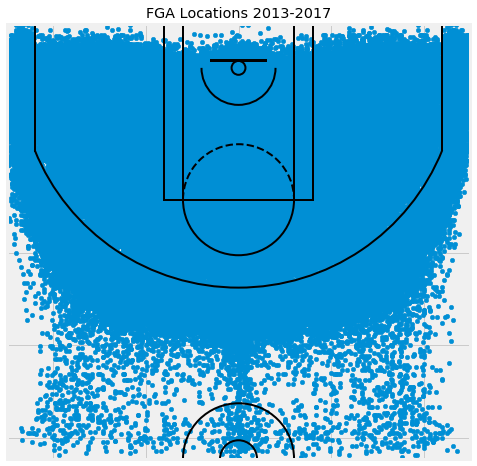

In [6]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("FGA Locations 2013-2017")

shot_charts_df.loc[half_court_mask].\
    plot.scatter(x='LOC_X', y='LOC_Y', ax=ax)
ax = draw_court(ax=ax, outer_lines=True)

### All Shots 2013

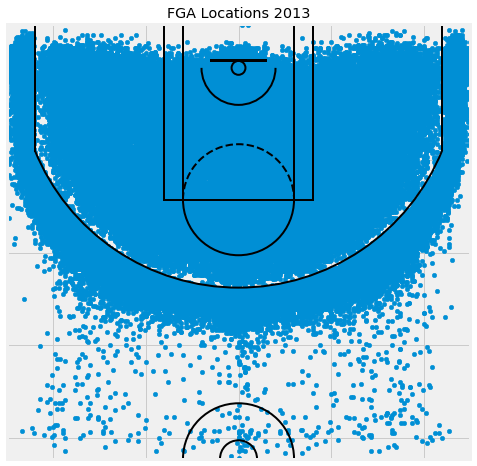

In [7]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("FGA Locations 2013")

shot_charts_df.loc[half_court_mask & mask_2013].\
    plot.scatter(x='LOC_X', y='LOC_Y', ax=ax)
ax = draw_court(ax=ax, outer_lines=True)

### All Shots 2017

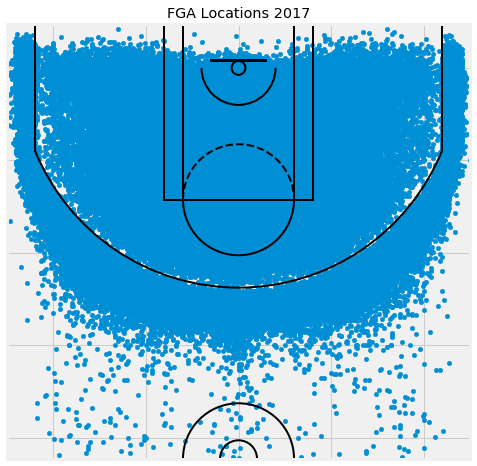

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("FGA Locations 2017")

shot_charts_df.loc[half_court_mask & mask_2017].\
    plot.scatter(x='LOC_X', y='LOC_Y', ax=ax)
ax = draw_court(ax=ax, outer_lines=True)

## League Average Characteristics

In [9]:
# shot X-Y locations
shot_x = shot_charts_df.LOC_X
shot_y = shot_charts_df.LOC_Y
shot_made = shot_charts_df.SHOT_MADE_FLAG
pts = shot_charts_df.PTS

### Create 2-Dimensional Bins

In [10]:
x_bins_lg = np.arange(-250, 265, 10)
y_bins_lg = np.arange(-60, 875, 10)
bins_lg = [x_bins_lg, y_bins_lg]

XX_lg, YY_lg = np.meshgrid(x_bins_lg, y_bins_lg)

# total shots in a bin
lg_fga_binned_result = binned_statistic_2d(
    shot_x, shot_y, None, bins=bins_lg, statistic='count')

lg_fga_bin_counts = lg_fga_binned_result.statistic
lg_fga_hist = lg_fga_bin_counts.T / lg_fga_bin_counts.sum()


def min_ct_mean(x, min_ct=25):
    """Return a mean if the count is high enough, otherwise nan"""
    if len(x) < min_ct:
        return np.nan
    else:
        return np.mean(x)
    
# FG% in a bin
lg_fgpct_binned_result = binned_statistic_2d(
    shot_x, shot_y, shot_made, bins=bins_lg, statistic=min_ct_mean)
lg_fgpct_binned = lg_fgpct_binned_result.statistic.T

# Pts per FGA in a bin (this is also eFG%)
lg_ppa_binned_result = binned_statistic_2d(
    shot_x, shot_y, pts, bins=bins_lg, statistic=min_ct_mean)
lg_ppa_binned = lg_ppa_binned_result.statistic.T

### League FGA by Location 2013-2017

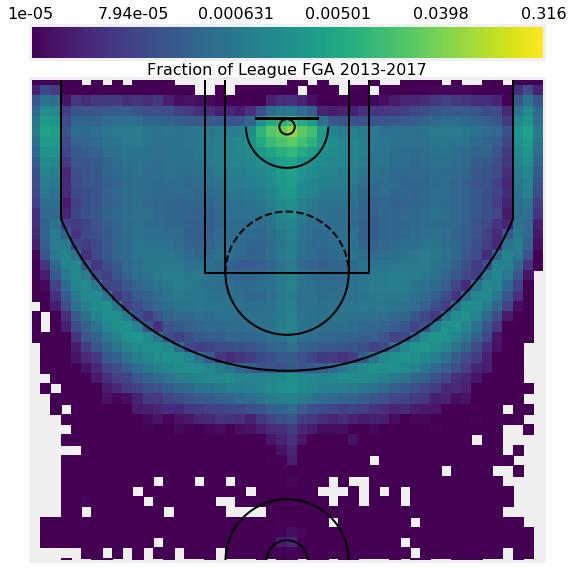

In [11]:
title = 'Fraction of League FGA 2013-2017'
draw_fraction_fga(XX_lg, YY_lg, lg_fga_hist, title)

### League FG% by Location 2013-2017

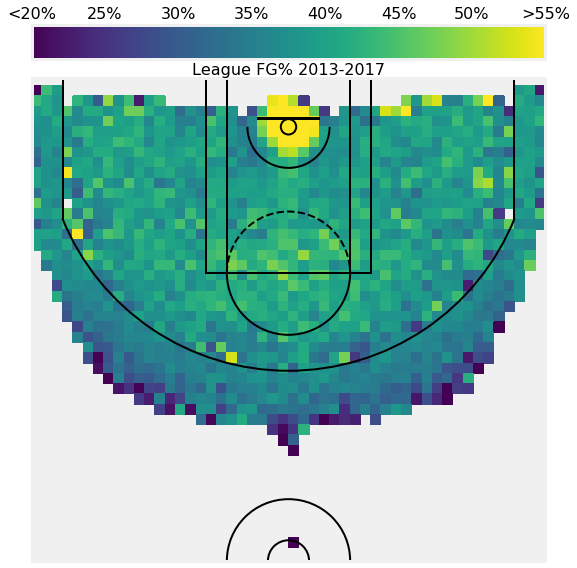

In [12]:
draw_fg_pct(XX_lg, YY_lg, lg_fgpct_binned, 'League FG% 2013-2017')

### League Pts per FGA or eFG% by Location 2013-2017

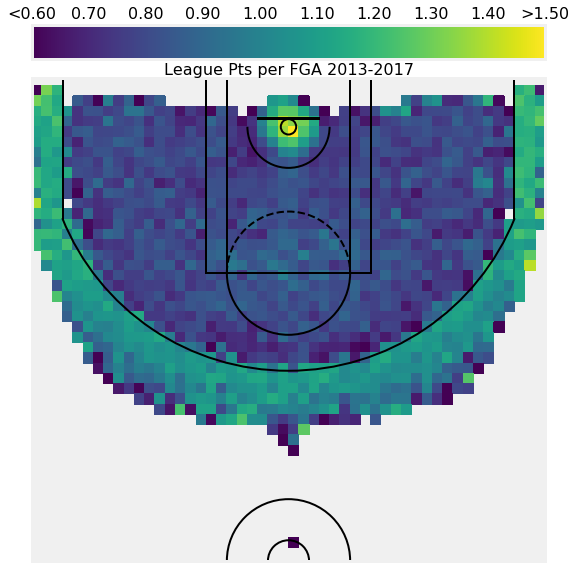

In [13]:
draw_ppa(XX_lg, YY_lg, lg_ppa_binned, 'League Pts per FGA 2013-2017')

### 2013

In [14]:
year_mask = mask_2013

# total shots in a bin
lg_fga_binned_result = binned_statistic_2d(
    shot_x.loc[year_mask], shot_y.loc[year_mask], None, 
    bins=bins_lg, statistic='count')

lg_fga_bin_counts = lg_fga_binned_result.statistic
lg_fga_hist = lg_fga_bin_counts.T / lg_fga_bin_counts.sum()
    
# FG% in a bin
lg_fgpct_binned_result = binned_statistic_2d(
    shot_x.loc[year_mask], shot_y.loc[year_mask], shot_made.loc[year_mask], 
    bins=bins_lg, statistic=min_ct_mean)
lg_fgpct_binned = lg_fgpct_binned_result.statistic.T

# Pts per FGA in a bin (this is also eFG%)
lg_ppa_binned_result = binned_statistic_2d(
    shot_x.loc[year_mask], shot_y.loc[year_mask], pts.loc[year_mask], 
    bins=bins_lg, statistic=min_ct_mean)
lg_ppa_binned = lg_ppa_binned_result.statistic.T

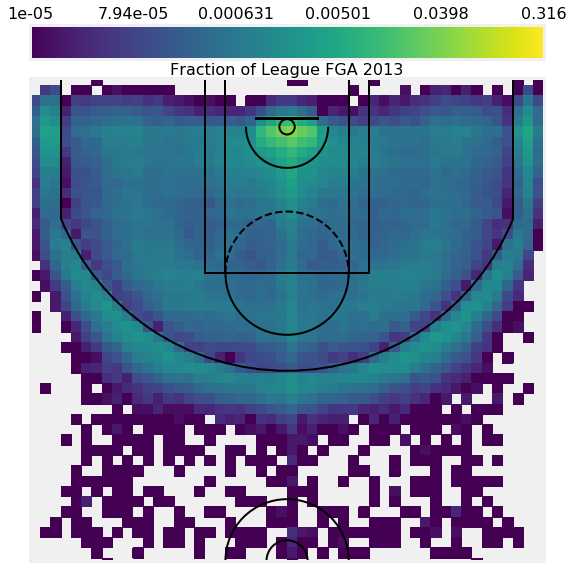

In [15]:
title = 'Fraction of League FGA 2013'
draw_fraction_fga(XX_lg, YY_lg, lg_fga_hist, title)

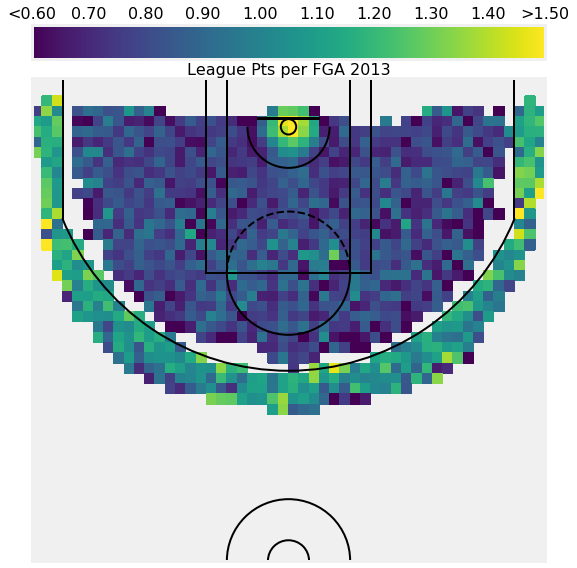

In [16]:
draw_ppa(XX_lg, YY_lg, lg_ppa_binned, 'League Pts per FGA 2013')

### 2017

In [17]:
year_mask = mask_2017

# total shots in a bin
lg_fga_binned_result = binned_statistic_2d(
    shot_x.loc[year_mask], shot_y.loc[year_mask], None, 
    bins=bins_lg, statistic='count')

lg_fga_bin_counts = lg_fga_binned_result.statistic
lg_fga_hist = lg_fga_bin_counts.T / lg_fga_bin_counts.sum()


# FG% in a bin
lg_fgpct_binned_result = binned_statistic_2d(
    shot_x.loc[year_mask], shot_y.loc[year_mask], shot_made.loc[year_mask], 
    bins=bins_lg, statistic=min_ct_mean)
lg_fgpct_binned = lg_fgpct_binned_result.statistic.T

# Pts per FGA in a bin (this is also eFG%)
lg_ppa_binned_result = binned_statistic_2d(
    shot_x.loc[year_mask], shot_y.loc[year_mask], pts.loc[year_mask], 
    bins=bins_lg, statistic=min_ct_mean)
lg_ppa_binned = lg_ppa_binned_result.statistic.T

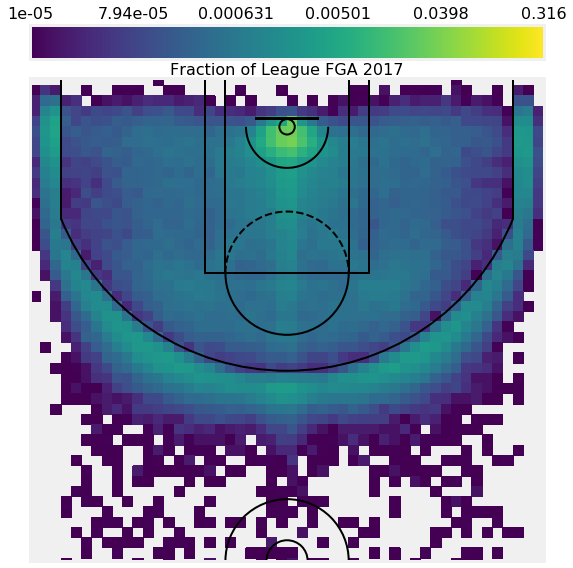

In [18]:
title = 'Fraction of League FGA 2017'
draw_fraction_fga(XX_lg, YY_lg, lg_fga_hist, title)

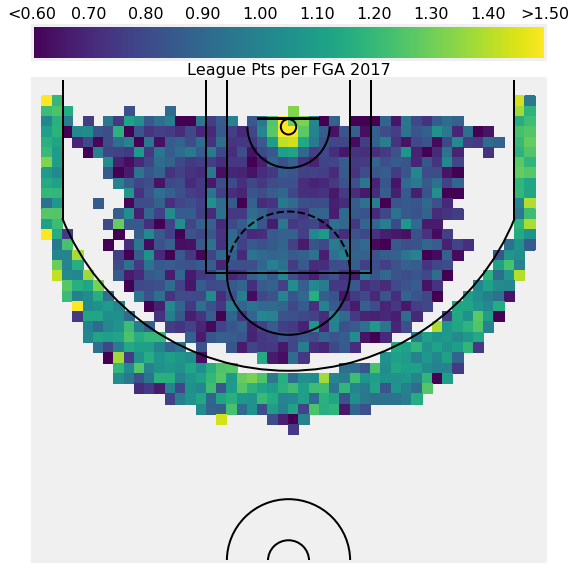

In [19]:
draw_ppa(XX_lg, YY_lg, lg_ppa_binned, 'League Pts per FGA 2017')

## FGA by Location for Teams

### Create 2-Dimensional Bins

In [20]:
x_bins_team = np.arange(-250, 265, 20)
y_bins_team = np.arange(-60, 875, 20)
bins_team = [x_bins_team, y_bins_team]

XX_team, YY_team = np.meshgrid(x_bins_team, y_bins_team)

In [21]:

# 2013 Dubs
mask_2013_dubs = dubs_mask & mask_2013

dubs_2013_fga_binned_result = binned_statistic_2d(
    shot_x.loc[mask_2013_dubs], 
    shot_y.loc[mask_2013_dubs], 
    None, 
    bins=bins_team, 
    statistic='count'
)

total_dubs_2013_shots = len(shot_y.loc[mask_2013_dubs])
dubs_2013_fga_bin_counts = dubs_2013_fga_binned_result.statistic
dubs_2013_fga_hist = dubs_2013_fga_bin_counts.T / total_dubs_2013_shots


# 2017 Dubs
mask_2017_dubs = dubs_mask & mask_2017

dubs_2017_fga_binned_result = binned_statistic_2d(
    shot_x.loc[mask_2017_dubs], 
    shot_y.loc[mask_2017_dubs], 
    None, 
    bins=bins_team, 
    statistic='count'
)

total_dubs_2017_shots = len(shot_y.loc[mask_2017_dubs])
dubs_2017_fga_bin_counts = dubs_2017_fga_binned_result.statistic
dubs_2017_fga_hist = dubs_2017_fga_bin_counts.T / total_dubs_2017_shots


# 2013 Rox
mask_2013_rox = rox_mask & mask_2013

rox_2013_fga_binned_result = binned_statistic_2d(
    shot_x.loc[mask_2013_rox], 
    shot_y.loc[mask_2013_rox], 
    None, 
    bins=bins_team, 
    statistic='count'
)

total_rox_2013_shots = len(shot_y.loc[mask_2013_rox])
rox_2013_fga_bin_counts = rox_2013_fga_binned_result.statistic
rox_2013_fga_hist = rox_2013_fga_bin_counts.T / total_rox_2013_shots

# 2017 Rox
mask_2017_rox = rox_mask & mask_2017

rox_2017_fga_binned_result = binned_statistic_2d(
    shot_x.loc[mask_2017_rox], 
    shot_y.loc[mask_2017_rox], 
    None, 
    bins=bins_team, 
    statistic='count'
)

total_rox_2017_shots = len(shot_y.loc[mask_2017_rox])
rox_2017_fga_bin_counts = rox_2017_fga_binned_result.statistic
rox_2017_fga_hist = rox_2017_fga_bin_counts.T / total_rox_2017_shots



# 2013 Lakers
mask_2013_lakes = lakes_mask & mask_2013
lakes_2013_fga_binned_result = binned_statistic_2d(
    shot_x.loc[mask_2013_lakes], 
    shot_y.loc[mask_2013_lakes], 
    None, 
    bins=bins_team, 
    statistic='count'
)

total_lakes_2013_shots = len(shot_y.loc[mask_2013_lakes])
lakes_2013_fga_bin_counts = lakes_2013_fga_binned_result.statistic
lakes_2013_fga_hist = lakes_2013_fga_bin_counts.T / total_lakes_2013_shots

# 2017 Lakers
mask_2017_lakes = lakes_mask & mask_2017
lakes_2017_fga_binned_result = binned_statistic_2d(
    shot_x.loc[mask_2017_lakes], 
    shot_y.loc[mask_2017_lakes], 
    None, 
    bins=bins_team, 
    statistic='count'
)

total_lakes_2017_shots = len(shot_y.loc[mask_2017_lakes])
lakes_2017_fga_bin_counts = lakes_2017_fga_binned_result.statistic
lakes_2017_fga_hist = lakes_2017_fga_bin_counts.T / total_lakes_2017_shots

### 2013 Dubs

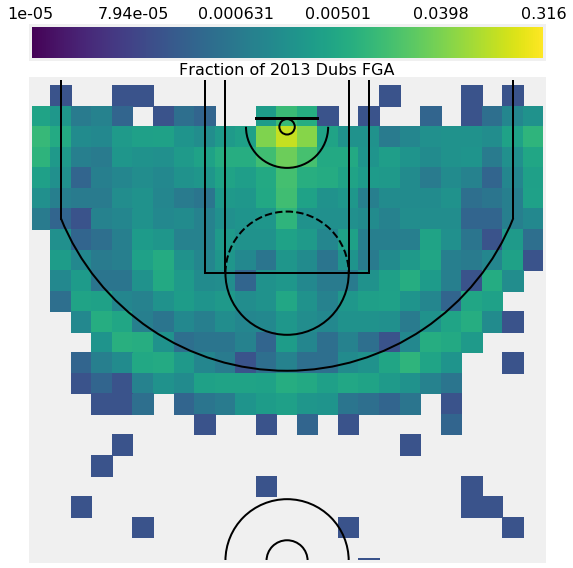

In [22]:
title = 'Fraction of 2013 Dubs FGA'
draw_fraction_fga(
    XX_team, YY_team, dubs_2013_fga_hist, title)

### 2017 Dubs

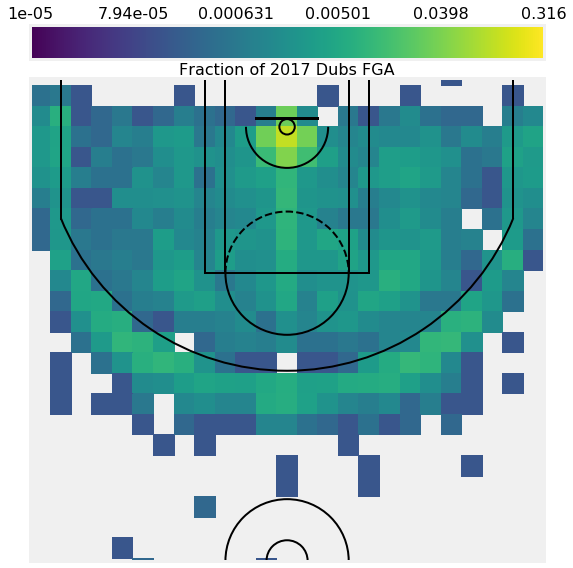

In [23]:
title = 'Fraction of 2017 Dubs FGA'
draw_fraction_fga(
    XX_team, YY_team, dubs_2017_fga_hist, title)

### 2013 Rox

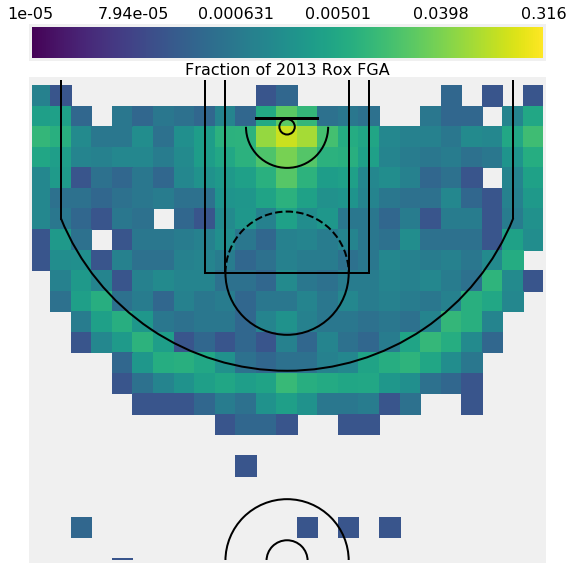

In [24]:
title = 'Fraction of 2013 Rox FGA'
draw_fraction_fga(
    XX_team, YY_team, rox_2013_fga_hist, title)

### 2017 Rox

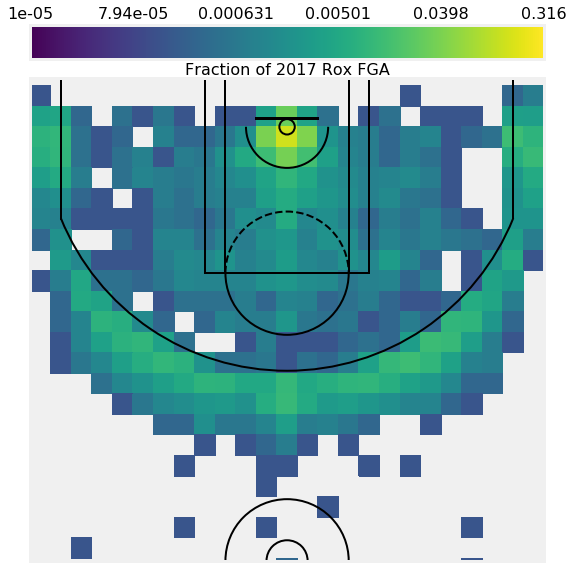

In [25]:
title = 'Fraction of 2017 Rox FGA'
draw_fraction_fga(
    XX_team, YY_team, rox_2017_fga_hist, title)

### 2013 Lakers

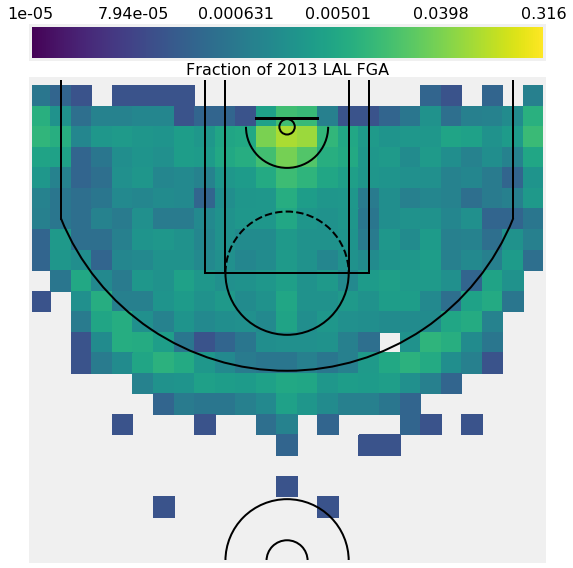

In [26]:
title = 'Fraction of 2013 LAL FGA'
draw_fraction_fga(
    XX_team, YY_team, lakes_2013_fga_hist, title)

### 2017 Lakers

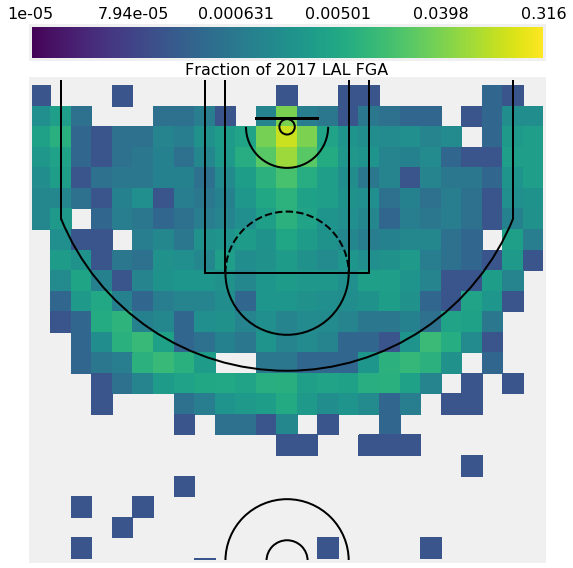

In [27]:
title = 'Fraction of 2017 LAL FGA'
draw_fraction_fga(
    XX_team, YY_team, lakes_2017_fga_hist, title)

## Smoothed Models for FG%

### All Shots 2013-2017

In [28]:
shot_dist = np.sqrt(shot_x**2 + shot_y**2)
shot_angle = np.arccos(shot_x / (shot_dist + 1e-8))

data_matrix = pd.DataFrame(
    {'shot_dist': shot_dist, 'shot_angle': shot_angle})
data_matrix.head()

,shot_dist,shot_angle
0,58.898,2.272
1,194.733,1.001
2,270.845,1.381
3,28.443,0.177
4,260.432,1.513


In [29]:
X_full = data_matrix.loc[half_court_mask & backboard_mask].values
idx = np.random.choice(X_full.shape[0], size=40000, replace=False)
X = X_full[idx, :]

y_full = shot_made.loc[half_court_mask & backboard_mask].values
y = y_full[idx]

In [30]:
model_formula = gam_spline(0, n_splines=10) + gam_interaction(0, 1, n_splines=[10, 10])
gam_model = LogisticGAM(model_formula)

lams = np.exp(np.random.rand(50, 3) * 4 - 2)
gam_model = gam_model.gridsearch(X, y, lam=lams)

N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--/usr/local/var/pyenv/versions/3.6.5/envs/data8/lib/python3.6/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
100% (50 of 50) |########################| Elapsed Time: 0:01:33 Time:  0:01:33


In [31]:
gam_model.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     23.0451
Link Function:                        LogitLink Log Likelihood:                                -26035.4216
Number of Samples:                        40000 AIC:                                            52116.9334
                                                AICc:                                           52116.9635
                                                UBRE:                                               3.3034
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0542
Feature Function                  Lam

In [32]:
gam_model.accuracy(X, y)

0.627525

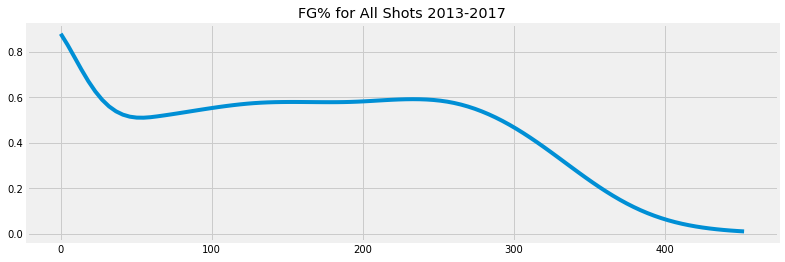

In [33]:
plot_fgpct_radial_dependence(gam_model, "FG% for All Shots 2013-2017")

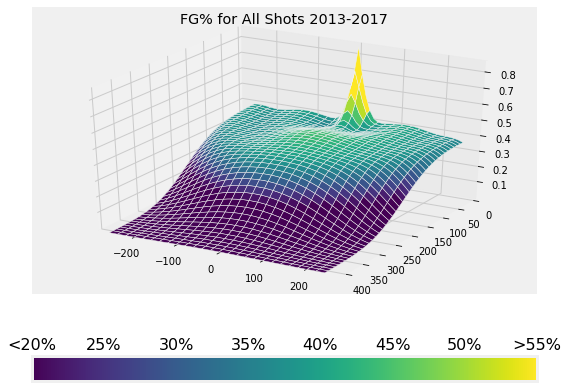

In [34]:
plot_fgpct_surface(gam_model, "FG% for All Shots 2013-2017")

/usr/local/var/pyenv/versions/3.6.5/envs/data8/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


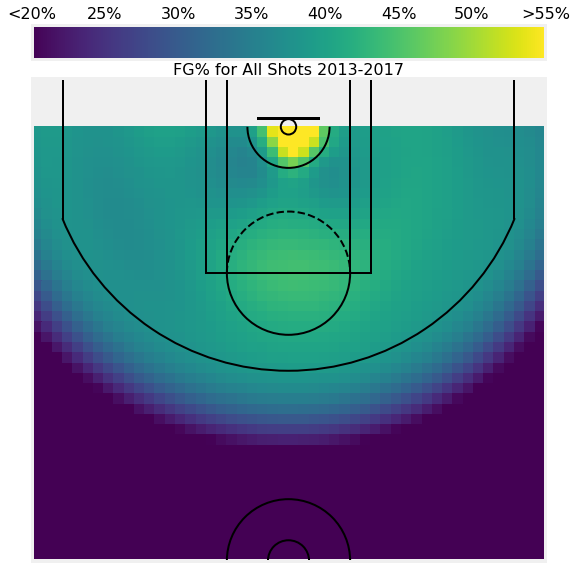

In [35]:
plot_fgpct_heatmap(gam_model, "FG% for All Shots 2013-2017")

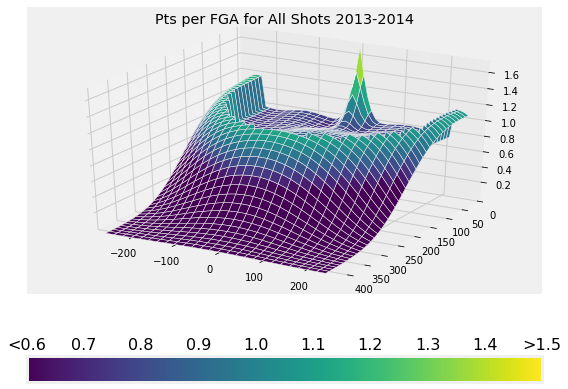

In [36]:
plot_ptsperfga_surface(gam_model, "Pts per FGA for All Shots 2013-2014")

/usr/local/var/pyenv/versions/3.6.5/envs/data8/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


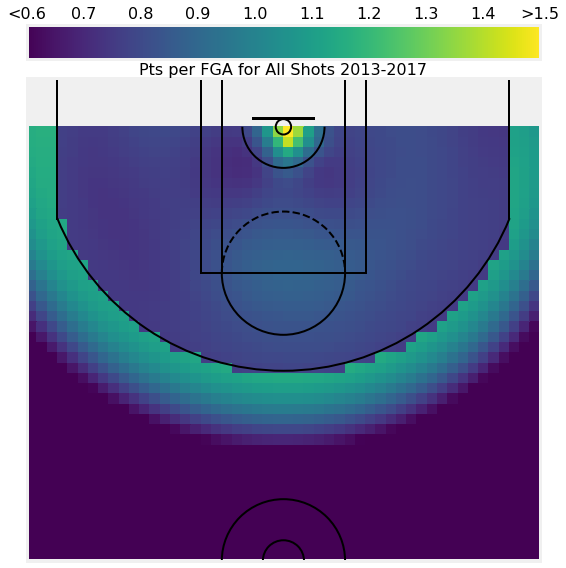

In [37]:
plot_ptsperfga_heatmap(gam_model, "Pts per FGA for All Shots 2013-2017")

## Incorporating Defender Distance (2013-2014)

In [38]:
shots_with_def_2014 = pd.read_csv('shots_2013-2014.csv.gz')
shots_with_def_2014['SEASON'] = 2014
shots_with_def_2015 = pd.read_csv('shots_2014-2015.csv.gz')
shots_with_def_2015['SEASON'] = 2015
shot_with_def_df = pd.concat(
    [shots_with_def_2014, shots_with_def_2015], ignore_index=True)

half_court_mask = (shot_with_def_df['LOC_Y'] < -47.5 + 470)
backboard_mask = (shot_with_def_df['LOC_Y'] >= 0)
open_shot_mask = shot_with_def_df.CLOSE_DEF_DIST >= 3
close_def_mask = shot_with_def_df.CLOSE_DEF_DIST <= 2

# shot X-Y locations
shot_x = shot_with_def_df.LOC_X
shot_y = shot_with_def_df.LOC_Y
shot_made = shot_with_def_df.SHOT_MADE_FLAG
pts = shot_with_def_df.PTS

shot_dist = np.sqrt(shot_x**2 + shot_y**2)
shot_angle = np.arccos(shot_x / (shot_dist + 1e-8))

data_matrix = pd.DataFrame(
    {'shot_dist': shot_dist, 'shot_angle': shot_angle})
data_matrix.head()

,shot_dist,shot_angle
0,105.394,0.583
1,90.211,0.628
2,188.876,2.160
3,192.388,1.960
4,172.177,1.107


### Open Shots 2013-2014

In [39]:
X_open_shots = data_matrix.loc[half_court_mask & backboard_mask & open_shot_mask].values
idx = np.random.choice(X_open_shots.shape[0], size=40000, replace=False)
X = X_open_shots[idx, :]

y_open_shots = shot_made.loc[half_court_mask & backboard_mask & open_shot_mask].values
y = y_open_shots[idx]

In [40]:
model_formula = gam_spline(0, n_splines=10) + gam_interaction(0, 1, n_splines=[10, 10])
gam_model = LogisticGAM(model_formula)

lams = np.exp(np.random.rand(50, 3) * 4 - 2)
gam_model = gam_model.gridsearch(X, y, lam=lams)

100% (50 of 50) |########################| Elapsed Time: 0:01:35 Time:  0:01:35


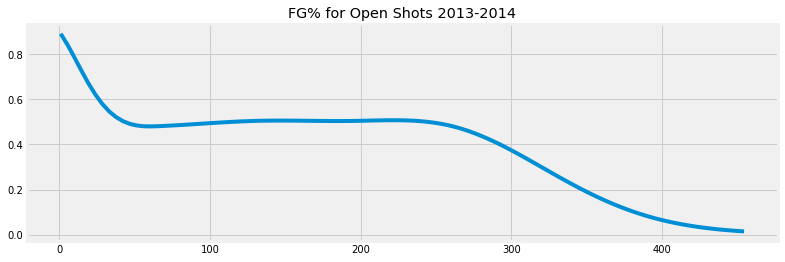

In [41]:
plot_fgpct_radial_dependence(gam_model, "FG% for Open Shots 2013-2014")

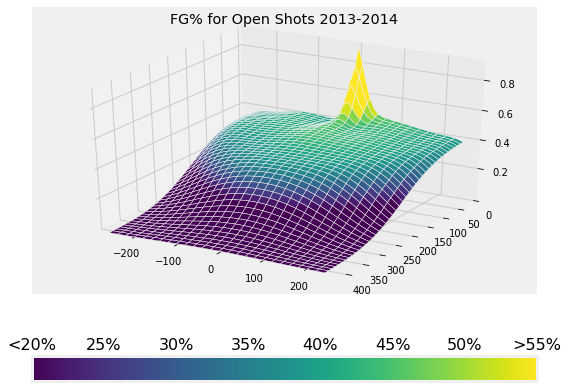

In [42]:
plot_fgpct_surface(gam_model, "FG% for Open Shots 2013-2014")

/usr/local/var/pyenv/versions/3.6.5/envs/data8/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


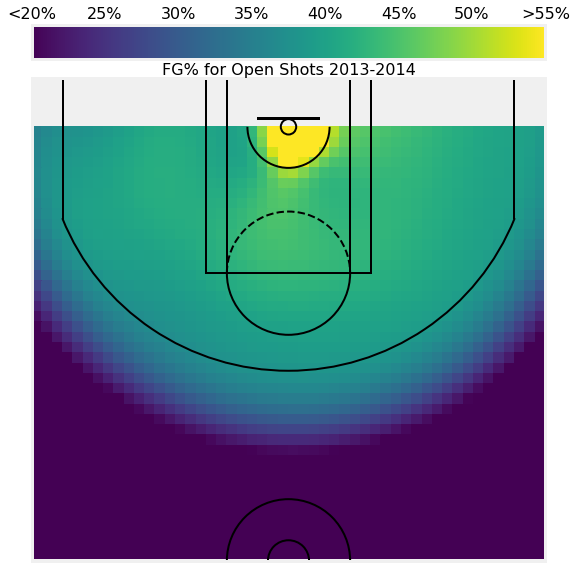

In [43]:
plot_fgpct_heatmap(gam_model, "FG% for Open Shots 2013-2014")

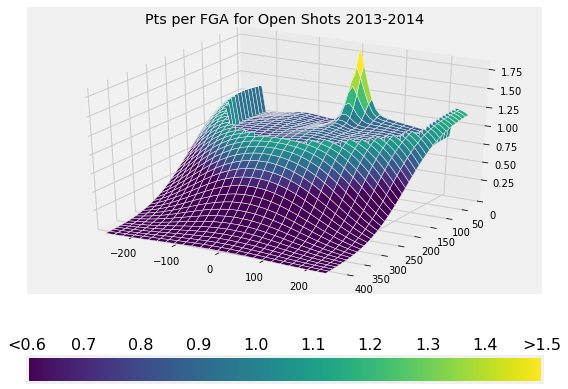

In [44]:
plot_ptsperfga_surface(gam_model, "Pts per FGA for Open Shots 2013-2014")

/usr/local/var/pyenv/versions/3.6.5/envs/data8/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


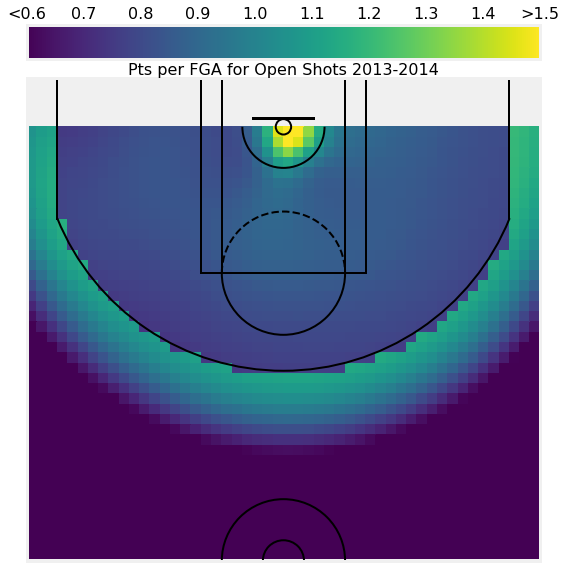

In [45]:
plot_ptsperfga_heatmap(gam_model, "Pts per FGA for Open Shots 2013-2014")

### Close Defender Shots 2013-2014

In [46]:
X_close_def = data_matrix.loc[half_court_mask & backboard_mask & close_def_mask].values
idx = np.random.choice(X_close_def.shape[0], size=40000, replace=False)
X = X_close_def[idx, :]

y_close_def = shot_made.loc[half_court_mask & backboard_mask & close_def_mask].values
y = y_close_def[idx]

In [47]:
model_formula = gam_spline(0, n_splines=10) + gam_interaction(0, 1, n_splines=[10, 10])
gam_model = LogisticGAM(model_formula)

lams = np.exp(np.random.rand(50, 3) * 4 - 2)
gam_model = gam_model.gridsearch(X, y, lam=lams)

100% (50 of 50) |########################| Elapsed Time: 0:01:38 Time:  0:01:38


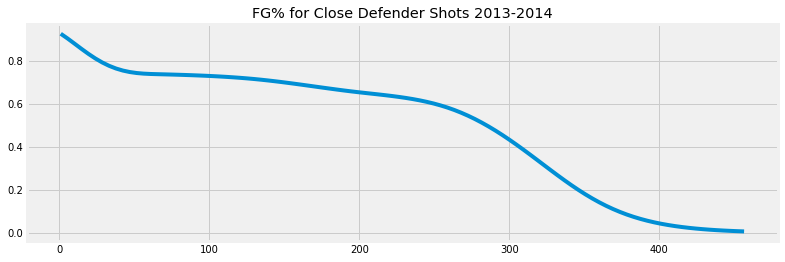

In [48]:
plot_fgpct_radial_dependence(gam_model, "FG% for Close Defender Shots 2013-2014")

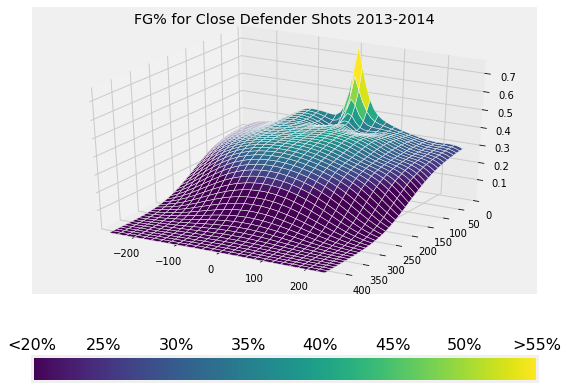

In [49]:
plot_fgpct_surface(gam_model, "FG% for Close Defender Shots 2013-2014")

/usr/local/var/pyenv/versions/3.6.5/envs/data8/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


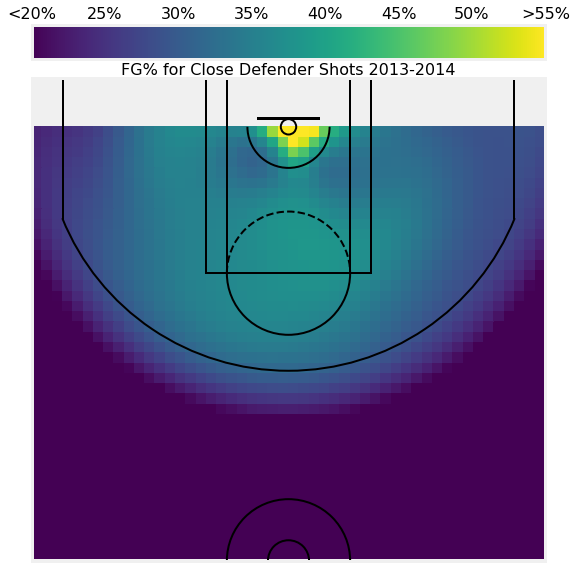

In [50]:
plot_fgpct_heatmap(gam_model, "FG% for Close Defender Shots 2013-2014")

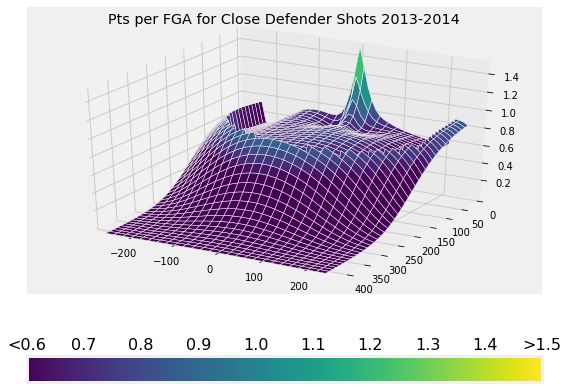

In [51]:
plot_ptsperfga_surface(gam_model, "Pts per FGA for Close Defender Shots 2013-2014")

/usr/local/var/pyenv/versions/3.6.5/envs/data8/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


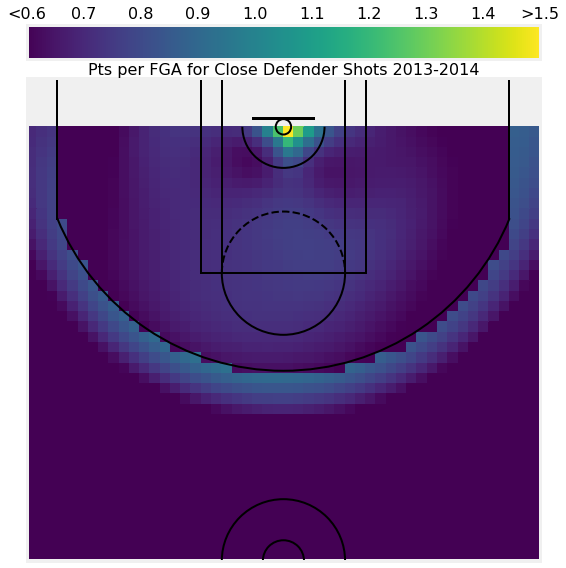

In [52]:
plot_ptsperfga_heatmap(gam_model, "Pts per FGA for Close Defender Shots 2013-2014")